PyTorch GRU based stock prediction model. Inspired by this Medium [article](https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f) and this Kaggle [post](https://www.kaggle.com/taronzakaryan/stock-prediction-lstm-using-pytorch) on stock prediction. I wanted to benchmark how a GRU performed compared to the LSTMs used previously.

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls "/content/gdrive/My Drive/GRU Stock Prediction/datasets"

PATH = '/content/gdrive/My Drive/GRU Stock Prediction/datasets/{symbol}'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
IBM.csv  TSLA.csv


In [57]:
import os
import math
import random
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Data shape: (15393, 1)
                 IBM
1962-01-02  7.626667
1962-01-03  7.693333
1962-01-04  7.616667
1962-01-05  7.466667
1962-01-08  7.326667


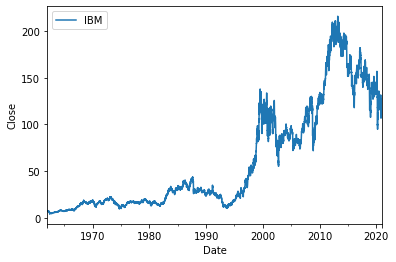

In [91]:
def fetch_df(symbols, dates, scale=True):
    '''
    csv loader and scaler for dataset
    source: https://blog.floydhub.com/gru-with-pytorch/
    '''
    df = pd.DataFrame(index=dates)
    label_scalers = {}

    for symbol in symbols:
        df_temp = pd.read_csv(PATH.format(symbol=symbol+'.csv'), index_col='Date', parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        if scale:
            # normalize input features
            sc = MinMaxScaler()
            label_sc = MinMaxScaler()
            data = sc.fit_transform(df_temp.values) 

            # store scaling for the labels when evaluating output
            label_sc.fit(df_temp.iloc[:,0].values.reshape(-1,1))
            label_scalers[symbol] = label_sc

            df_temp[:] = data
        
        df = df.join(df_temp)
        
    return df, label_scalers

# symbols = ['TSLA']
symbols = ['IBM']
dates = pd.date_range(start='1962-01-02',end='2020-12-31 ',freq='B')
df, label_scalers = fetch_df(symbols, dates, scale=False)

print('Data shape:',df.shape)
print(df.head(5))

df = df.fillna(method='ffill')
df.interpolate().plot()
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

Split into test and training sets. 

In [92]:
# def min_max_scalar(x, feature_range=(0,1), dim=0):
#     '''
#     replicates behaviour of sklearn.preprocessing.MinMaxScalar
#     '''
#     x_std = (x - x.min(dim, keepdim=True).values) / (x.max(dim, keepdim=True).values - x.min(dim, keepdim=True).values)
#     x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
#     return x_scaled, x_std


def symbol_loader(df, symbol, lookback=20, test_split=0.2, shuffle=False):
    '''
    convert df of symbol close prices to a tensor array with (n-lookback) sequences of `lookback`
    '''
    price = torch.tensor(df[symbol].values)
    T = len(price) - lookback
    data = torch.zeros(T, lookback)

    for i in range(T):
        data[i,:] = price[i:i+lookback]
    
    test_size = int(test_split * T)
    train_size = T - test_size

    idx = list(range(T))

    if shuffle:
        random.shuffle(idx)

    print(data.shape)
    data = data.view(T, -1, 1)
    print(data.shape)

    x_train = data[idx[:train_size], :-1, :]
    y_train = data[idx[:train_size], -1, :]
    x_test = data[idx[train_size:test_size+train_size], :-1, :]
    y_test = data[idx[train_size:test_size+train_size], -1, :]

    return x_train, y_train, x_test, y_test, idx


lookback = 20
x_train, y_train, x_test, y_test, idx = symbol_loader(df, 'IBM', lookback)

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

torch.Size([15373, 20])
torch.Size([15373, 20, 1])
x_train.shape: torch.Size([12299, 19, 1])
y_train.shape: torch.Size([12299, 1])
x_test.shape: torch.Size([3074, 19, 1])
y_test.shape: torch.Size([3074, 1])


In [93]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, drop=0.2, bi=False, activation='relu'):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop, bidirectional=bi)
        if activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Tanh()
        self.fc = nn.Linear(hidden_dim, output_dim)
    

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden


    def forward(self, x, h):
        x, h = self.gru(x,h)
        x = self.fc(self.act(x[:,-1]))
        return x, h

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, drop=0.2, activation='relu'):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop)
        if activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Tanh()
        self.fc = nn.Linear(hidden_dim, output_dim)
    

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), 
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden


    def forward(self, x, h):
        x, h = self.lstm(x,h)
        x = self.fc(self.act(x[:,-1]))
        return x, h


In [94]:
def model_summary(model):
    print('Model Summary\n')
    print('Layer Name'+'\t'*7+'Number of Parameters')
    print('='*100)
    model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
    layer_name = [child for child in model.children()]
    j = 0
    total_params = 0
    print('\t'*10)
    for i in layer_name:
        print()
        param = 0
        try:
            bias = (i.bias is not None)
        except:
            bias = False  
        if not bias:
            param = model_parameters[j].numel()+model_parameters[j+1].numel()
            j = j + 2
        else:
            param = model_parameters[j].numel()
            j = j + 1
        print(str(i)+'\t'*3+str(param))
        total_params+=param
    print('='*100)
    print(f'Total Params:{total_params}')


In [97]:
'''
Set parameters, initialize dataloader
'''
batch_size = 16
epochs = 100
lr = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

traindata = TensorDataset(x_train, y_train)
trainloader = DataLoader(traindata, shuffle=True, batch_size=batch_size, drop_last=True)
testdata = TensorDataset(x_test, y_test)
testloader = DataLoader(testdata, shuffle=True, batch_size=batch_size, drop_last=True)

In [98]:
def validate(net, testloader, model='GRU'):
    criterion = nn.MSELoss()
    loss = 0

    # net.eval()

    h = net.init_hidden(batch_size)
    if model == 'GRU':
        h = h.data
    else:
        h = tuple([h_ for h_ in h])
    
    for i, data in enumerate(testloader, 0):
        input, label = data
        input, label = input.to(device), label.to(device)
        with torch.no_grad():
            output, h = net(input, h)
            loss += criterion(output, label.to(device).float())

    return loss / len(testloader)

def train(trainloader, testloader, lr=0.01, hidden_dim=128, epochs=5, n_layers=2, model='GRU', act='relu', drop=0.2):
    input_dim = next(iter(trainloader))[0].shape[2]
    output_dim = 1
    
    '''instantiate models'''
    if model == 'GRU':
        net = GRUNet(input_dim, hidden_dim, n_layers, output_dim, drop=drop, activation=act)
    else:
        net = LSTMNet(input_dim, hidden_dim, n_layers, output_dim, drop=drop, activation=act)
    # model_summary(net)
    net.to(device)
    net.train()

    '''criterion and optimizer'''
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    '''train for specified epochs'''
    print('Starting training...')
    start = time.time()

    losses = []
    val_losses = []
    c = 0

    for epoch in range(epochs):
        h = net.init_hidden(batch_size)
        running_loss = 0.
        
        for i, data in enumerate(trainloader, 1):
            input, label = data

            optimizer.zero_grad()
            net.zero_grad()

            if model == 'GRU':
                h = h.data
            else:
                h = tuple([h_.data for h_ in h])


            out, h = net(input.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # losses.append(loss.item())

            if c % 100 == 0:
                val_loss = validate(net, testloader, model=model)
                print('Epoch: {} \tStep: {}/{} \tAverage training loss: {:.5f}\tAverage validation loss: {:.5f}'.format(epoch+1, i, len(trainloader), running_loss/i, val_loss))
                losses.append(loss.item())
                val_losses.append(val_loss)

            c += 1   

    print('Training complete... Final Loss: {}\nSeconds elapsed:{}'.format(loss, time.time()-start))
    return net, losses, val_losses



lstm_net, lstm_loss, lstm_val_loss = train(trainloader, testloader, lr, model='LSTM', n_layers=2, epochs=epochs, act='tanh', drop=0.2)
gru_net, gru_loss, gru_val_loss = train(trainloader, testloader, lr, model='GRU', n_layers=2, epochs=epochs, act='tanh', drop=0.2)


Starting training...
Epoch: 1 	Step: 1/768 	Average training loss: 5356.57861	Average validation loss: 24914.97266
Epoch: 1 	Step: 101/768 	Average training loss: 2129.83354	Average validation loss: 20883.08398
Epoch: 1 	Step: 201/768 	Average training loss: 1842.68909	Average validation loss: 18776.98047
Epoch: 1 	Step: 301/768 	Average training loss: 1673.28755	Average validation loss: 17233.45312
Epoch: 1 	Step: 401/768 	Average training loss: 1546.98399	Average validation loss: 16289.48047
Epoch: 1 	Step: 501/768 	Average training loss: 1437.81115	Average validation loss: 15322.38574
Epoch: 1 	Step: 601/768 	Average training loss: 1330.52635	Average validation loss: 13605.10449
Epoch: 1 	Step: 701/768 	Average training loss: 1230.35663	Average validation loss: 12116.91602
Epoch: 2 	Step: 33/768 	Average training loss: 402.66461	Average validation loss: 10890.47070
Epoch: 2 	Step: 133/768 	Average training loss: 390.62860	Average validation loss: 9799.00391
Epoch: 2 	Step: 233/768 	

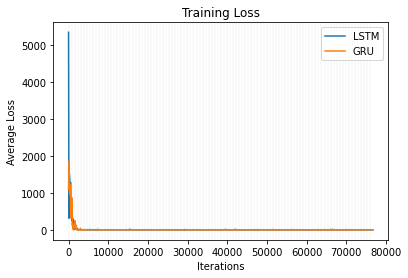

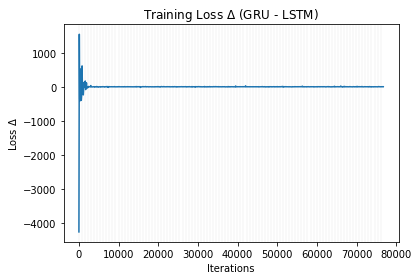

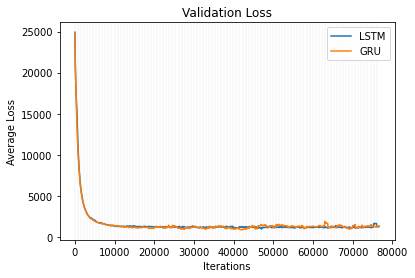

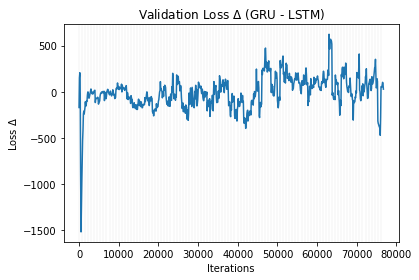

Final LSTM validation loss:1319.904296875
Final GRU validation loss:1326.589111328125


In [99]:
iters = list(range(1, epochs*len(trainloader), 100))

def epoch_lines():
    for x in range(0, iters[-1], len(trainloader)):
        plt.axvline(x=x, lw=0.05, c='black')

_, ax1 = plt.subplots()
ax1.plot(iters, lstm_loss)
ax1.plot(iters, gru_loss)
epoch_lines()
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Average Loss')
plt.legend(['LSTM','GRU'])
plt.show()

_, ax2 = plt.subplots()
ax2.plot(iters, [gru_loss[i]-lstm_loss[i] for i in range(len(lstm_loss))])
plt.title('Training Loss $\Delta$ (GRU - LSTM)')
epoch_lines()
plt.xlabel('Iterations')
plt.ylabel('Loss $\Delta$')
plt.show()

_, ax3 = plt.subplots()
ax3.plot(iters, lstm_val_loss)
ax3.plot(iters, gru_val_loss)
epoch_lines()
plt.title('Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Average Loss')
plt.legend(['LSTM','GRU'])
plt.show()

_, ax4 = plt.subplots()
ax4.plot(iters, [gru_val_loss[i]-lstm_val_loss[i] for i in range(len(lstm_val_loss))])
epoch_lines()
plt.title('Validation Loss $\Delta$ (GRU - LSTM)')
plt.xlabel('Iterations')
plt.ylabel('Loss $\Delta$')
plt.show()

lstm_eval = validate(lstm_net, testloader, model='LSTM')
gru_eval = validate(gru_net, testloader, model='GRU')

print('Final LSTM validation loss:{}'.format(lstm_eval))
print('Final GRU validation loss:{}'.format(gru_eval))


In [ ]:
'''
TODO:
get loss on test set and graph
fit the original stock curve
USE SCALED DATA 'data' instead of df
'''

In [ ]:
'''
Dataset augmentation - ideas:
1. Use the open prices for stocks as a separate dataset
2. Add Gaussian Noise to the dataset
3. Run sequences backwards - market doesn't seem symmetrical though

Notes:
Stateful vs stateless?
What is causing the large jumps with epochs?
Variable learning rate
Tweak parameters and hyperparameters
Test multiple symbols at the same time
Tanh vs ReLU?
'''